In [1]:
%load_ext autoreload
%autoreload 2

### Set seed:

In [2]:
# Imports
import time
import numpy as np
import numba as nb
import random
import torch
import copy

# Set seed
seed = 1998
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
#torch.use_deterministic_algorithms(True)

### Local imports:

In [4]:
# Environment
from base_env import BaseEnv
from buffer_stock_env import BufferStockEnv

# Plotting
from history import History
from show_results import *

# RL
from agent import Agent
from dp_agent import DPAgent
from td3_agent import TD3Agent
from replay_buffer import ReplayBuffer
from networks import Actor, Critic

# DP
from DP_solution import BufferStockModelClass
from consav.misc import elapsed

### Globals:

In [5]:
T = 20
rho = 1.0
beta = 0.96

testing_episodes = 5000  # Number of episodes to test
training_episodes = 1000  # Number of episodes to train

### Solve Buffer-Stock with and without shock using DP:

In [6]:
# Normal model without shock
kwargs = {'solmethod':'egm', 'T':T, 'rho':rho, 'beta':beta}
model = BufferStockModelClass(name='baseline', par=kwargs)
model.solve()

 t = 19 solved in 0.4 secs
 t = 18 solved in 1.6 secs (w: 0.8 secs)
 t = 17 solved in 0.2 secs (w: 0.2 secs)
 t = 16 solved in 0.2 secs (w: 0.2 secs)
 t = 15 solved in 0.2 secs (w: 0.2 secs)
 t = 14 solved in 0.2 secs (w: 0.2 secs)
 t = 13 solved in 0.2 secs (w: 0.2 secs)
 t = 12 solved in 0.2 secs (w: 0.2 secs)
 t = 11 solved in 0.2 secs (w: 0.2 secs)
 t = 10 solved in 0.3 secs (w: 0.3 secs)
 t = 9 solved in 0.3 secs (w: 0.3 secs)
 t = 8 solved in 0.2 secs (w: 0.2 secs)
 t = 7 solved in 0.2 secs (w: 0.2 secs)
 t = 6 solved in 0.2 secs (w: 0.2 secs)
 t = 5 solved in 0.2 secs (w: 0.2 secs)
 t = 4 solved in 0.2 secs (w: 0.2 secs)
 t = 3 solved in 0.2 secs (w: 0.2 secs)
 t = 2 solved in 0.2 secs (w: 0.2 secs)
 t = 1 solved in 0.2 secs (w: 0.2 secs)
 t = 0 solved in 0.2 secs (w: 0.2 secs)


In [7]:
# Model with shock to mu (mu = 0.1 -> mu = 0.25) 
kwargs_shock = {'solmethod':'egm', 'T':T-5, 'rho':rho, 'beta':beta, 'mu':0.25}
model_shock = BufferStockModelClass(name='shock', par=kwargs_shock)
model_shock.solve()

 t = 14 solved in 0.4 secs
 t = 13 solved in 1.4 secs (w: 0.8 secs)
 t = 12 solved in 0.2 secs (w: 0.2 secs)
 t = 11 solved in 0.2 secs (w: 0.2 secs)
 t = 10 solved in 0.2 secs (w: 0.2 secs)
 t = 9 solved in 0.2 secs (w: 0.2 secs)
 t = 8 solved in 0.2 secs (w: 0.2 secs)
 t = 7 solved in 0.2 secs (w: 0.2 secs)
 t = 6 solved in 0.2 secs (w: 0.2 secs)
 t = 5 solved in 0.2 secs (w: 0.2 secs)
 t = 4 solved in 0.2 secs (w: 0.2 secs)
 t = 3 solved in 0.2 secs (w: 0.2 secs)
 t = 2 solved in 0.2 secs (w: 0.2 secs)
 t = 1 solved in 0.3 secs (w: 0.3 secs)
 t = 0 solved in 0.2 secs (w: 0.2 secs)


### Train TD3 agent in Buffer-Stock environment ***without*** shock:

In [8]:
# Initialize environment
env = BufferStockEnv(T=T, rho=rho, beta=beta)
env.seed(1998)

# Initialize TD3 agent
action_dim = env.action_space.shape[0]
state_dim = env.observation_space.shape[0]
td3_agent = TD3Agent(state_dim, action_dim, beta=beta)

# Simulate interaction
td3_agent.interact(env, training_episodes, train=True)

Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000


### Compare TD3 and DP agent in enviroment ***without*** shock: 

In [9]:
# Initialize DP agent
dp_agent = DPAgent(model, env)

# Simulate interaction
td3_agent.interact(env, testing_episodes, train=False)
dp_agent.interact(env, testing_episodes, train=False)

# Save history
td3_agent.history.save('td3_agent.pkl')
dp_agent.history.save('dp_agent.pkl')

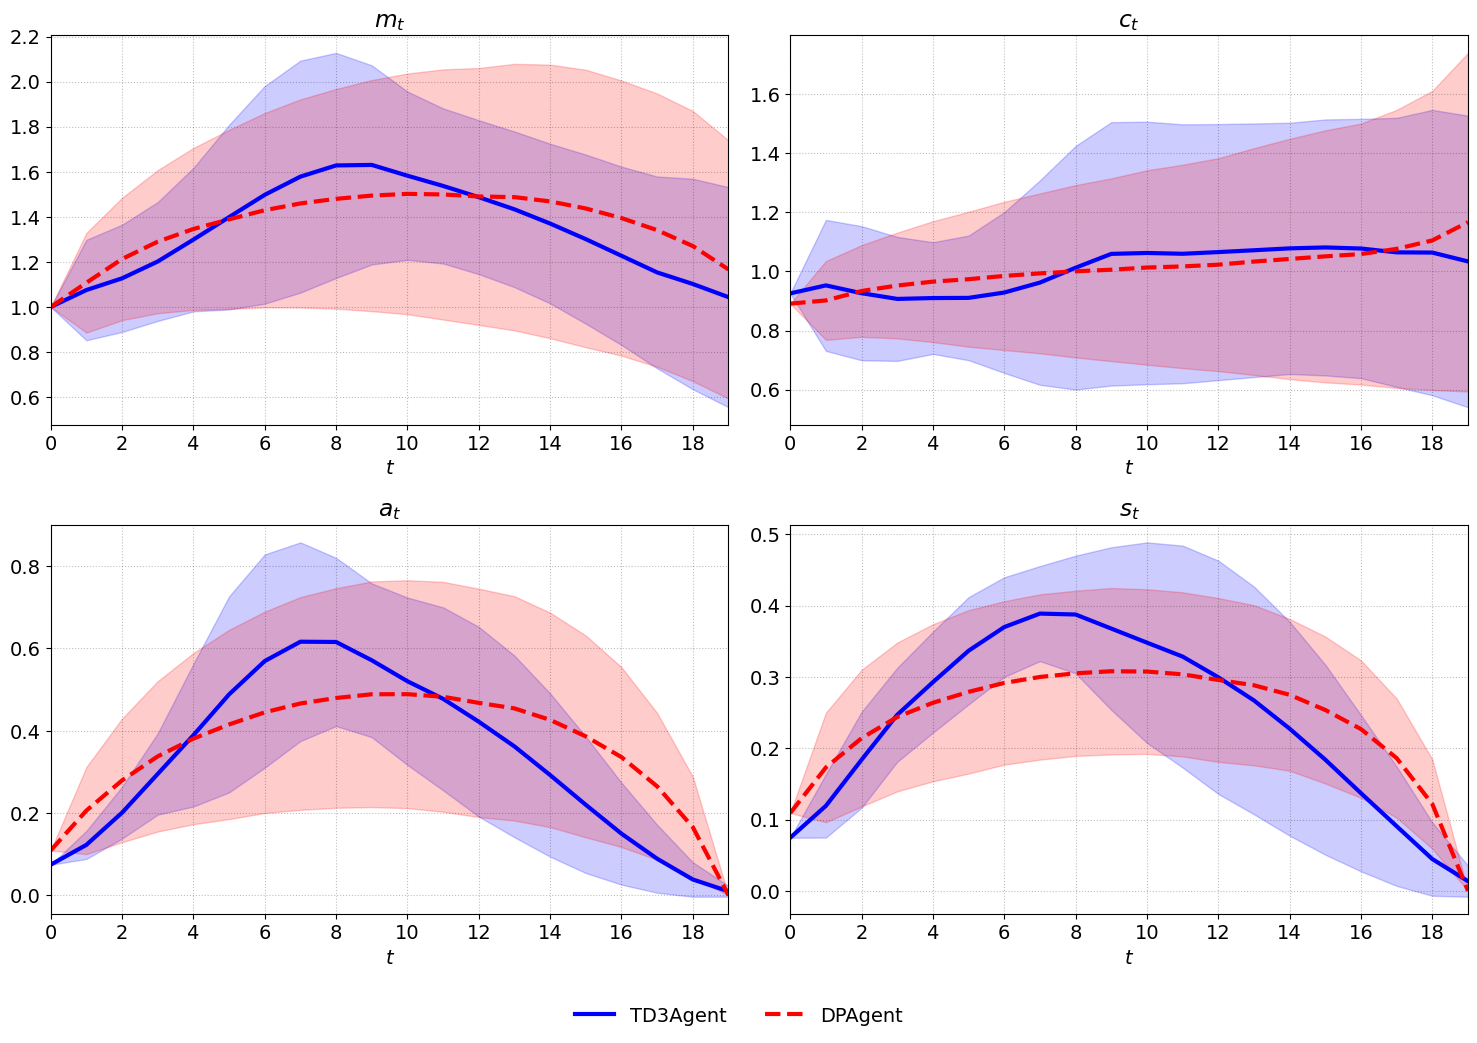

In [10]:
var_list = ['m','c','a','s']
agents = (td3_agent, dp_agent)
plot_avg_trajectories_separate(*agents, var_list=var_list, con_bands=True, save=True)

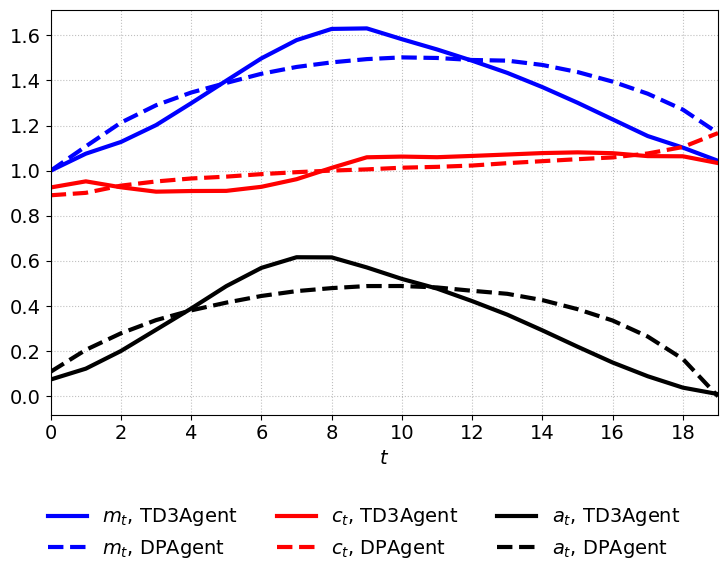

In [11]:
var_list = ['m','c','a']
plot_avg_trajectories_together(*agents, var_list=var_list, start_period1=0, start_period2=0, con_bands=False)

In [12]:
generate_avg_values_table(*agents, var_list=['m','c','a','s','value'])

\begin{table}
\caption{Average Values and Standard Deviations}
\label{tab:avg_values}
\begin{tabular}{lrrrr}
\toprule
Agent & \multicolumn{2}{r}{TD3Agent} & \multicolumn{2}{r}{DPAgent} \\
Statistic & Average & Standard deviation & Average & Standard deviation \\
Variable &  &  &  &  \\
\midrule
m & 1.33 & 0.43 & 1.36 & 0.51 \\
c & 1.01 & 0.38 & 1.01 & 0.35 \\
a & 0.33 & 0.26 & 0.35 & 0.26 \\
s & 0.24 & 0.16 & 0.24 & 0.13 \\
value & -0.51 & 2.23 & -0.39 & 2.27 \\
\bottomrule
\end{tabular}
\end{table}



### Create new enviroment with shock to $\mu$:

In [13]:
mid = int(env.T/4)

# Initial states
avg_mid_m = np.mean(td3_agent.history.m[:,mid], axis=0)
avg_mid_p = np.mean(td3_agent.history.p[:,mid], axis=0)

print(f'mid: {mid}')
print(f'avg_mid_m: {avg_mid_m:.2f}')
print(f'avg_mid_p: {avg_mid_p:.2f}')

mid: 5
avg_mid_m: 1.40
avg_mid_p: 1.00


In [14]:
# New initial value for states (average in T = 5)
state_vars = [
    {'name': 'p', 'ini': avg_mid_p, 'low': 0.0, 'high': 100},
    {'name': 'm', 'ini': avg_mid_m, 'low': 0.0, 'high': 100},
    {'name': 't', 'ini': mid/env.T, 'low': 0.0, 'high': 1.0}
]

# Initialize new environment
env_change = BufferStockEnv( 
    state_vars=state_vars, 
    T=20,
    mu = 0.25, 
    reset_period=mid
)

### Train TD3 agent in Buffer-Stock environment ***with*** shock:

In [15]:
# Train in new environment
td3_agent.interact(env_change, training_episodes, train=True)

# Load to reuse history for T < 5
td3_agent.history = History.load('td3_agent.pkl')

# Test in new environment
td3_agent.interact(env_change, testing_episodes, train=False, keep_history=True)

# Save history
td3_agent.history.save('td3_agent_change.pkl')

Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 600
Episode 700
Episode 800
Episode 900
Episode 1000


### Compare trajectories with and without shock:

In [16]:
# Load histories
no_change = History.load('td3_agent.pkl')
with_change = History.load('td3_agent_change.pkl')

# Names for labels in plots
no_change.name = f'{td3_agent.__class__.__name__}, no shock'
with_change.name = f'{td3_agent.__class__.__name__}, shock to $\mu$ at $T=5$'

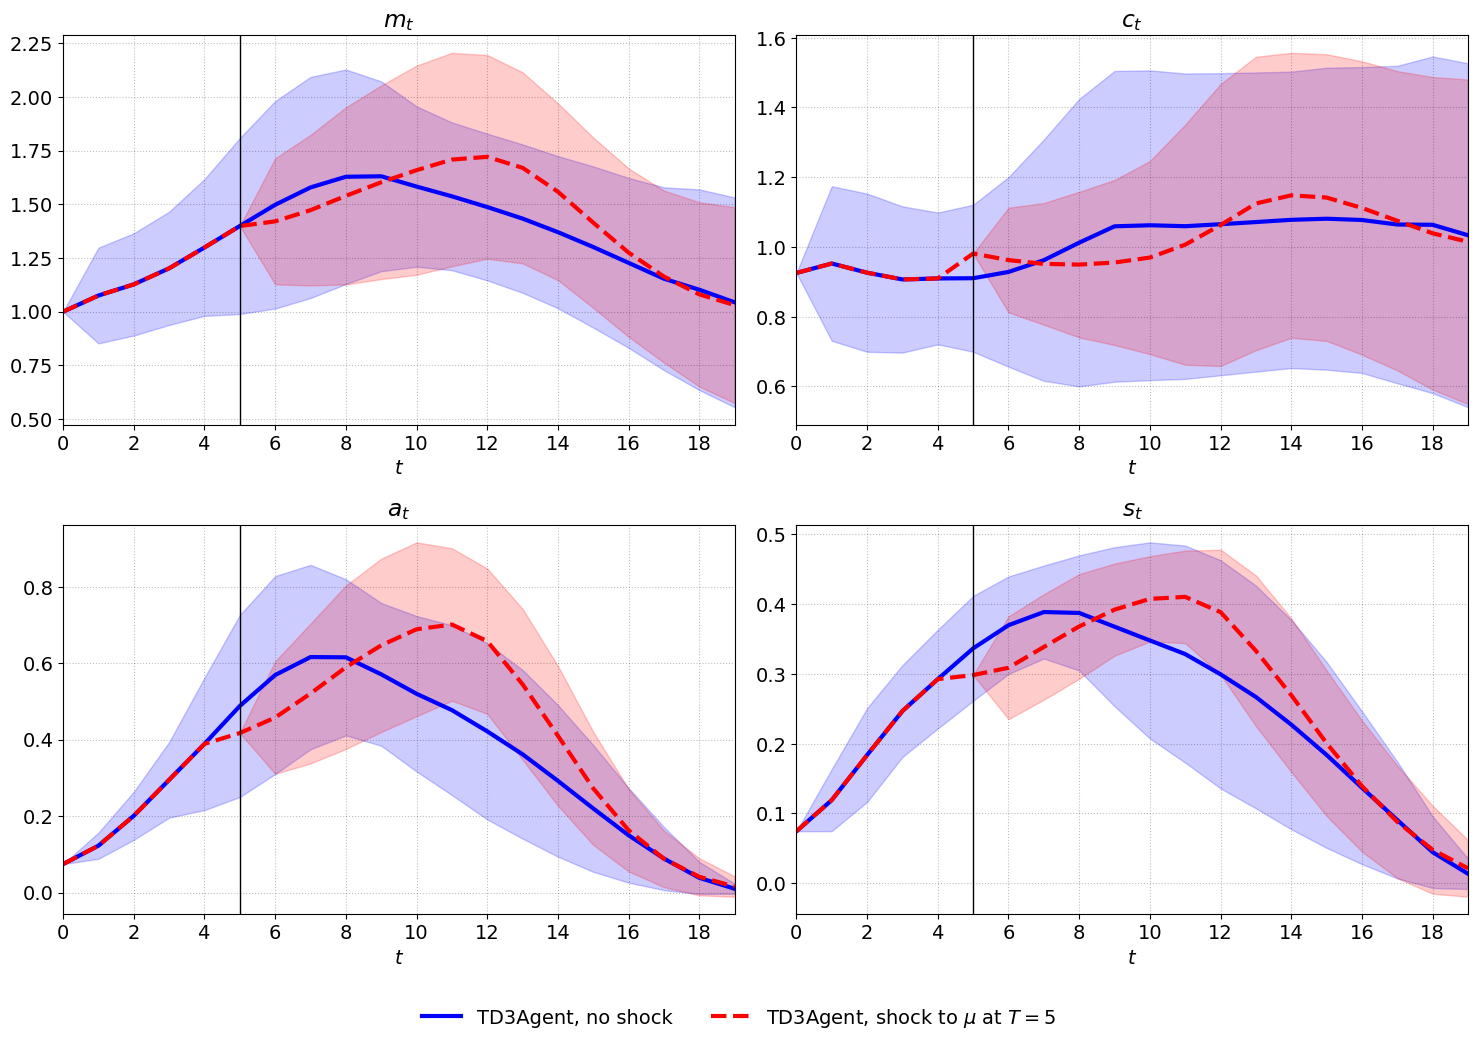

In [17]:
var_list = ['m','c','a','s']
histories = (no_change, with_change)
plot_avg_trajectories_separate(*histories, var_list=var_list, con_bands=True, start_period2=mid, save=True)

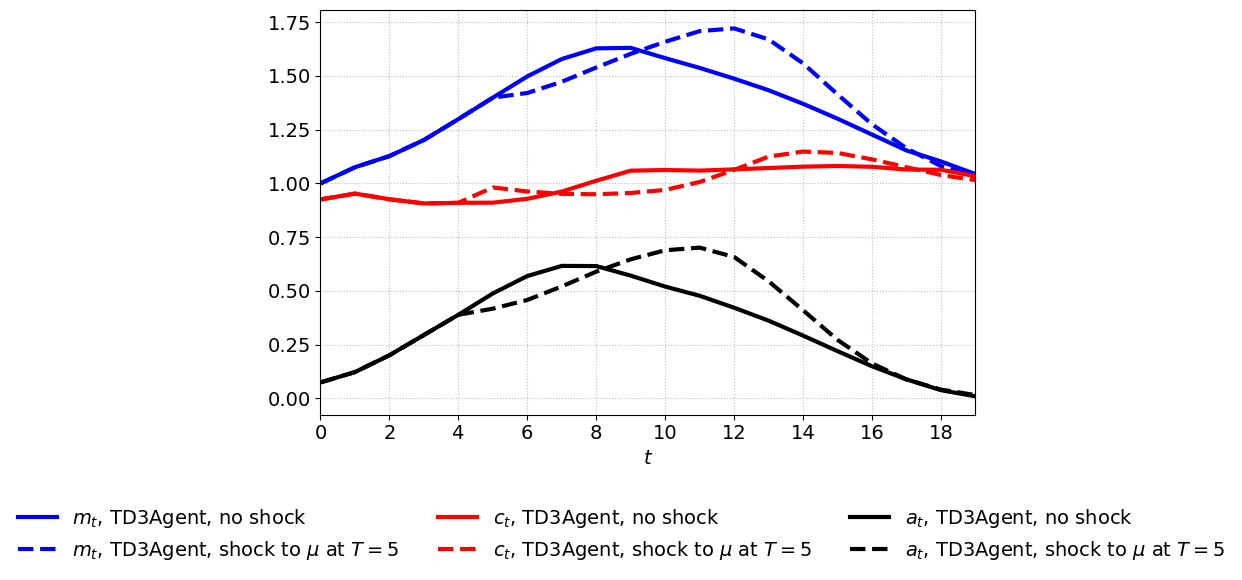

In [18]:
var_list = ['m','c','a']
plot_avg_trajectories_together(*histories, var_list=var_list, start_period1=0, start_period2=0, con_bands=False, save=True)

### Compare TD3 and DP agent in enviroment ***with*** shock:

In [19]:
# Simulate DP interaction
dp_agent = DPAgent(model_shock, env_change)
dp_agent.history = History.load('dp_agent.pkl')
dp_agent.history.name = f'{dp_agent.__class__.__name__}, shock to $\mu$ at $T=5$'
dp_agent.interact(env_change, testing_episodes, train=False, shift=5, keep_history=True)

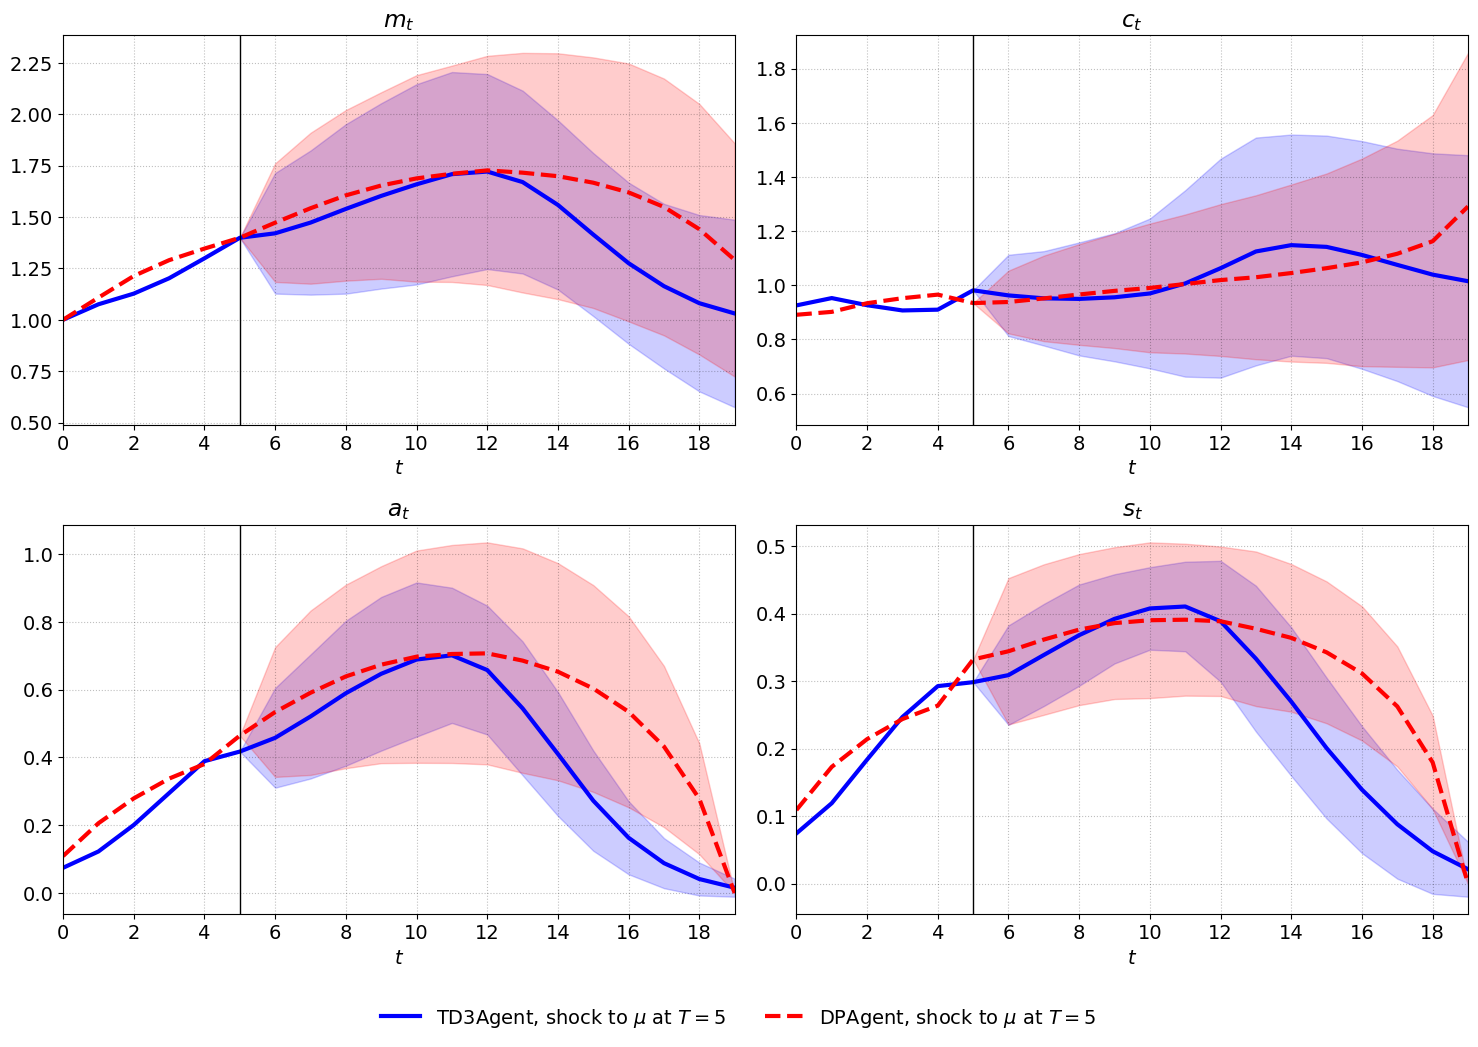

In [20]:
var_list = ['m','c','a','s']
histories = (with_change, dp_agent)
plot_avg_trajectories_separate(*histories, var_list=var_list, con_bands=True, start_period1=mid, start_period2=mid, save=True)